# Introduction

This project aims to build a convolutional neural network for multiclass image classification using numpy. Broadly, this is an extension of my [previous project](https://github.com/Shmuley322/multilayer-perceptron-on-MNIST) and consequently I tried  making up for the general shortcomings of my previous neural net in addition to moving up from MLP to CNN. 

Outline:
- I first describe the network
- Then I take the dataset from the [Digit Recognizer Kaggle Challenge](https://www.kaggle.com/competitions/digit-recognizer) to train my CNN
- After that I make a prediction on the test data and submit it for evaluation
- Finally, I discuss the problems I faced during creation of this network and whether I was able to improve compared to the previous project

This notebook uses my network as a module, the source code for which can be found in the corresponding folder. 

# Network description

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from my_cnn.CNN import Classifier

Classifier is a CNN that may consist of any number and sequence of convolutional, max pooling and fully connected linear layers. All of the layers are connected sequentially. Following is a description of each layer in detail:

Convolutional layer:
- supports any number of kernels
- activated with ReLU
- performs convolution with a square kernel, 0 padding and stride 1

Max pooling layer:
- performs max pooling with a square kernel, 0 padding and stride 1
- does not learn

Linear layer: 
- number of neurons is equal to the product of dimensions of an output of a reduction of previous layers, in other words it is fully connected with neurons of a previous layer
- activated with softmax

Loss function is cross-entropy. 

# Model initialization and training

Import the data and do some preprocessing

In [2]:
train_data = pd.read_csv('data/mnist_train.csv')
y_train = train_data['label'].astype(np.int8)
X_train = train_data.drop(['label'], axis=1).to_numpy().reshape((len(train_data), 28, 28))
X_train = (X_train / 255).astype(np.float32)

The classifier will consists of a convolutional layer with 7 6x6 kernels, a max pooling layer with a 4x4 kernel and a linear layer with an output size of 10. 

In [6]:
architecture = 'conv pool lin'
n_classes = len(set(y_train))
layer_params = [(6, 10), (4,), (n_classes)]
input_size = X_train[0].shape

Initialize the model and train it

In [7]:
cfr = Classifier(architecture, layer_params, n_classes, input_size)
cfr.fit(X_train, y_train, learning_rate=1e-3, n_epochs=10)

Epoch 1/10, sample 41999/42000, loss 0.53318
Loss: 0.533	 balanced accuracy on train: 0.849


KeyboardInterrupt: 

In [9]:
import pickle
with open('model3.pkl', 'rb') as file:
    cfr2 = pickle.load(file)

In [10]:
n_kernels = cfr2.layers[0].kernel.shape[2]
n_kernels

7

In [11]:
test_data = pd.read_csv('data/mnist_test.csv')
X_test = test_data.to_numpy().reshape((len(test_data), 28, 28))
X_test = (X_test / 255).astype(np.float32)

In [15]:
prediction = cfr2.predict(X_test[0:1])

In [13]:
y_pred = pd.DataFrame(prediction, columns=['Label'])
y_pred.index += 1
y_pred['Label'].to_csv('data/submission.csv', index_label='ImageId')

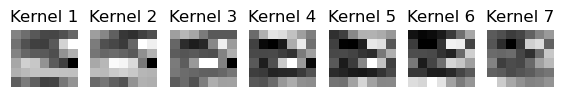

In [23]:
fig, ax = plt.subplots(1, n_kernels, figsize=(n_kernels, 5))
for i in range(n_kernels):
    ax[i].imshow(cfr2.layers[0].kernel[:,:,i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Kernel {i + 1}')

Big thanks to [Ahlad Kumar](https://www.youtube.com/@AhladKumar) for his [series](https://www.youtube.com/playlist?list=PLdxQ7SoCLQAMeMPpRvqXJjBSmKey0SdlH) on CNN.

cupy did not work
numba did not work
Todo: hyperparameter tuning

In [7]:
n_samples = len(X_train)
start = 0
samples = range(start, start + n_samples)
correct = 0
for sample in samples:
    print(f'Sample {sample}, accuracy {correct / (sample + 1e-6)}', end='\r')
    out = cfr.predict(X_train[sample])
    true_label = y_train[sample]
    correct += out == true_label

KeyboardInterrupt: 